<a href="https://colab.research.google.com/github/AAP9002/COMP34812-NLU-NLI/blob/main/NLI_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transformer based Approach for NLI

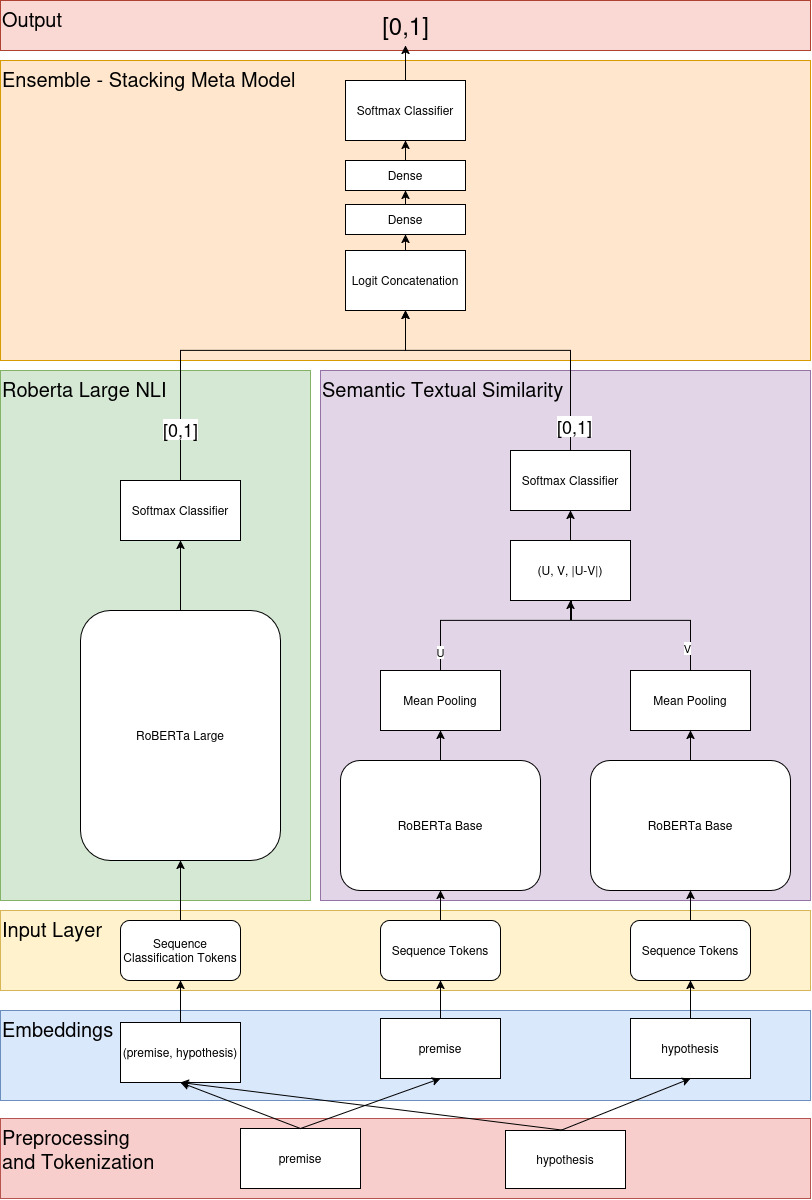

In [1]:
RANDOM_STATE = 42
BATCH_SIZE = 10

FORCE_TRAIN_ALL = False

In [2]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
from transformers import AutoTokenizer,TFAutoModel, TFRobertaForSequenceClassification
from huggingface_hub import snapshot_download


import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Helper Functions

In [3]:
def plot_history(history):
  losses = history.history['loss']
  val_losses = history.history['val_loss']
  epochs = range(1, len(losses) + 1)

  try:
    accuracy = history.history['binary_accuracy']
    val_accuracy = history.history['val_binary_accuracy']
  except:
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

  plt.figure(figsize=(12, 4))

  plt.subplot(1, 2, 1)
  plt.plot(epochs, losses, 'r', label='Training loss')
  plt.plot(epochs, val_losses, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(epochs, accuracy, 'r', label='Training accuracy')
  plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.show()

def plot_confussion(true, pred, title):
  cm = tf.math.confusion_matrix(true, pred)
  cm = cm.numpy()
  cm = cm / cm.sum(axis=1, keepdims=True)
  plt.figure(figsize=(8, 6))

  sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues')
  plt.title(title)
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.show()

  return cm

# Pre-process text

In [4]:
# set HF_TOKEN in your enviroment

# load datasets
snapshot_download(repo_id="aap9002/NLU-Coursework",  repo_type="dataset", allow_patterns=f"*", local_dir='./')

if not FORCE_TRAIN_ALL:
  # load model weights
  snapshot_download(repo_id="aap9002/NLU_NLI_Models", allow_patterns=f"*", local_dir='./')

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

dev.csv:   0%|          | 0.00/1.17M [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/2.46k [00:00<?, ?B/s]

train.csv:   0%|          | 0.00/4.26M [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

.gitattributes:   0%|          | 0.00/1.52k [00:00<?, ?B/s]

nli_large_roberta_model.h5:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

ensamble_model_weights_and_arch.h5:   0%|          | 0.00/659M [00:00<?, ?B/s]

similarity_model.h5:   0%|          | 0.00/501M [00:00<?, ?B/s]

In [5]:
def get_split_datasets():
  dev_set = pd.read_csv('dev.csv')
  train_set = pd.read_csv('train.csv')

  # create a test set out of validation if no test.csv exists
  try:
      test_set = pd.read_csv('test.csv')
  except:
      test_set = dev_set.sample(frac=0.2, random_state=RANDOM_STATE) # random state set for reproducability
      dev_set = dev_set.drop(test_set.index)

      test_set.reset_index()
      dev_set.reset_index()

  return train_set, dev_set, test_set

train_set, dev_set, test_set = get_split_datasets()

In [6]:
print(f"train set shape:{train_set.shape}")
train_set.head()

train set shape:(24432, 3)


,premise,hypothesis,label
0,yeah i don't know cut California in half or so...,Yeah. I'm not sure how to make that fit. Maybe...,1
1,actual names will not be used,"For the sake of privacy, actual names are not ...",1
2,The film was directed by Randall Wallace.,The film was directed by Randall Wallace and s...,1
3,"""How d'you know he'll sign me on?""Anse studie...",Anse looked at himself in a cracked mirror.,1
4,In the light of the candles his cheeks looked ...,Drew regarded his best friend and noted that i...,1


In [7]:
print(f"dev set shape:{dev_set.shape}")
dev_set.head()

dev set shape:(5389, 3)


,premise,hypothesis,label
0,"By starting at the soft underbelly, the 16,000...","General Nelson A. Miles had 30,000 troops in h...",0
1,"The class had broken into a light sweat, but w...",The class grew more tense as time went on.,1
2,"Samson had his famous haircut here, but he wou...",It was unknown where exactly within the town S...,1
3,A man with a black shirt holds a baby while a ...,A darkly dressed man passes a crying baby to a...,0
4,I know that many of you are interested in addr...,The problems must be addressed,1


In [8]:
print(f"test set shape:{test_set.shape}")
test_set.head()

test set shape:(1347, 3)


,premise,hypothesis,label
381,"In any event, auditors need to make judgments ...","In any event, auditors do not have to make any...",0
2877,"Visit us, even if it's just for tea or a walk ...",The tea here is among the finest globally.,1
5314,As the sophistication and the number of edits ...,Improvements are costly to the agency.,1
2018,This most symbolic of Crete's religious relics...,Crete never lost possession of its important r...,0
2185,Just as he had experienced disappointment the ...,His betrayal made him feel completely numb and...,1


In [9]:
train_set = train_set.dropna(subset=['label'])
dev_set = dev_set.dropna(subset=['label'])
test_set = test_set.dropna(subset=['label'])

## Explore dataset

class balence
- Our dataset is labelled with a 0 or 1 to indicate a supporting or contradicting permissive hypothesis pair

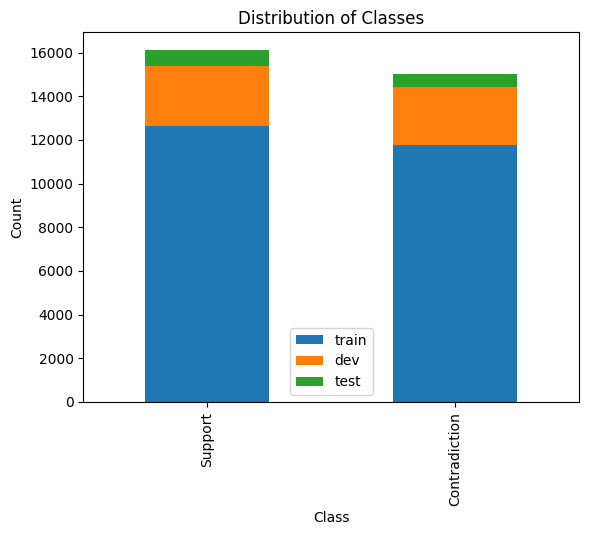

In [10]:

def get_class_balance(train_set, dev_set, test_set):
  label_map = {
      0: 'Contradiction',
      1: 'Support'
  }

  labels_counts = [train_set['label'].value_counts(), dev_set['label'].value_counts(), test_set['label'].value_counts()]
  labels_counts = pd.concat(labels_counts, axis=1)
  labels_counts.columns = ['train', 'dev', 'test']

  # set label names
  labels_counts.index = labels_counts.index.map(label_map)

  labels_counts.plot(kind="bar", stacked=True, title="Distribution of Classes", xlabel="Class", ylabel="Count")
  plt.show()

  return labels_counts

labels_counts = get_class_balance(train_set, dev_set, test_set)

Average word counts of premise and hypothosis

In [11]:
premise_counts = [train_set['premise'].str.split().str.len(), dev_set['premise'].str.split().str.len(), test_set['premise'].str.split().str.len()]
hypothesis_counts = [train_set['hypothesis'].str.split().str.len(), dev_set['hypothesis'].str.split().str.len(), test_set['hypothesis'].str.split().str.len()]

premise_counts = pd.concat(premise_counts, axis=1)
hypothesis_counts = pd.concat(hypothesis_counts, axis=1)

premise_counts.columns = ['train', 'dev', 'test']
hypothesis_counts.columns = ['train', 'dev', 'test']

print(f"Premise:\n{premise_counts.describe()}\n")
print(f"Hypothesis:\n{hypothesis_counts.describe()}\n")

Premise:
              train          dev         test
count  24432.000000  5389.000000  1347.000000
mean      18.915766    18.582668    18.540460
std       13.132731    12.086228    11.804328
min        0.000000     1.000000     1.000000
25%       10.000000    10.000000    10.000000
50%       16.000000    16.000000    16.000000
75%       24.000000    24.000000    24.000000
max      281.000000   139.000000    96.000000

Hypothesis:
              train          dev         test
count  24432.000000  5389.000000  1347.000000
mean      10.447323    10.457413    10.411284
std        4.784198     4.802937     4.651299
min        1.000000     1.000000     1.000000
25%        7.000000     7.000000     7.000000
50%       10.000000    10.000000    10.000000
75%       13.000000    13.000000    13.000000
max       45.000000    44.000000    30.000000



# RoBERTa NLI Binary Classification Model

In [12]:
roberta_large_tokenizer = AutoTokenizer.from_pretrained("FacebookAI/roberta-large")

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

### Data preparation

In [13]:
train_set

,premise,hypothesis,label
0,yeah i don't know cut California in half or so...,Yeah. I'm not sure how to make that fit. Maybe...,1
1,actual names will not be used,"For the sake of privacy, actual names are not ...",1
2,The film was directed by Randall Wallace.,The film was directed by Randall Wallace and s...,1
3,"""How d'you know he'll sign me on?""Anse studie...",Anse looked at himself in a cracked mirror.,1
4,In the light of the candles his cheeks looked ...,Drew regarded his best friend and noted that i...,1
...,...,...,...
24427,"Additionally, the analogy touches on what migh...",The analogy was drawn due to economic reasons.,1
24428,Guests have the option of dining in cozy rooms...,"There are no dining facilities, though there a...",0
24429,A lady is carrying an infant near a window.,The lady's hands are unoccupied.,0
24430,"A mattress pad, also known as a mattress toppe...","A mattress pad, mattress topper, or underpad i...",1


Prepate input sequence and labels

In [14]:
def token_sequence(pairs, labels):
  premises = [premise for premise, hypo in pairs.values]
  hypotheses = [hypo for premise, hypo in pairs.values]

  # tokenize
  encodings = roberta_large_tokenizer(
      premises,
      hypotheses,
      padding=True,
      truncation=True,
      return_tensors="tf"
  )

  labels = tf.one_hot(labels, depth=2) # comment if we wish to use multi-class
  dataset = tf.data.Dataset.from_tensor_slices((dict(encodings), labels))
  return dataset


train_embeddings = token_sequence(train_set[['premise', 'hypothesis']], train_set['label'])
dev_embeddings = token_sequence(dev_set[['premise', 'hypothesis']], dev_set['label'])
test_embeddings = token_sequence(test_set[['premise', 'hypothesis']], test_set['label'])

In [15]:
train_batches_roberta_large_nli = train_embeddings.batch(BATCH_SIZE)
dev_batches_roberta_large_nli = dev_embeddings.batch(BATCH_SIZE)
test_batches_roberta_large_nli = test_embeddings.batch(BATCH_SIZE)

## Fine-Tune RoBERTa Binary Classification Model

In [16]:
# roberta_large_model = TFRobertaForSequenceClassification.from_pretrained("FacebookAI/roberta-base", num_labels=2)
roberta_large_model = TFRobertaForSequenceClassification.from_pretrained(
    "FacebookAI/roberta-large",
    num_labels=2,
    )

N = 6  # Number of layers to freeze
for layer in roberta_large_model.roberta.encoder.layer[:N]:
    layer.trainable = False
print(f"Freezing first {N} layers of {len(roberta_large_model.roberta.encoder.layer)} roberta")

roberta_large_model.summary()

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

Freezing first 6 layers of 24 roberta
Model: "tf_roberta_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 roberta (TFRobertaMainLaye  multiple                  354310144 
 r)                                                              
                                                                 
 classifier (TFRobertaClass  multiple                  1051650   
 ificationHead)                                                  
                                                                 
Total params: 355361794 (1.32 GB)
Trainable params: 279784450 (1.04 GB)
Non-trainable params: 75577344 (288.30 MB)
_________________________________________________________________


In [17]:
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = [tf.keras.metrics.BinaryAccuracy(name='binary_accuracy', threshold=0.5)]

roberta_large_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [18]:
if os.path.exists('nli_large_roberta_model.h5'):
    roberta_large_model.load_weights('nli_large_roberta_model.h5')
    print("Model was loaded from weights")
else:
  history = roberta_large_model.fit(train_batches_roberta_large_nli, validation_data=dev_batches_roberta_large_nli , epochs=5)
  plot_history(history)

Model was loaded from weights


## Evaluate Model

In [19]:
loss, accuracy = roberta_large_model.evaluate(dev_batches_roberta_large_nli)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

539/539 [==============================] - 42s 56ms/step - loss: 0.3871 - binary_accuracy: 0.9088
Test Loss: 0.3871433734893799
Test Accuracy: 0.9087957143783569


539/539 [==============================] - 36s 54ms/step
              precision    recall  f1-score   support

           0       0.91      0.90      0.91      2630
           1       0.91      0.91      0.91      2759

    accuracy                           0.91      5389
   macro avg       0.91      0.91      0.91      5389
weighted avg       0.91      0.91      0.91      5389



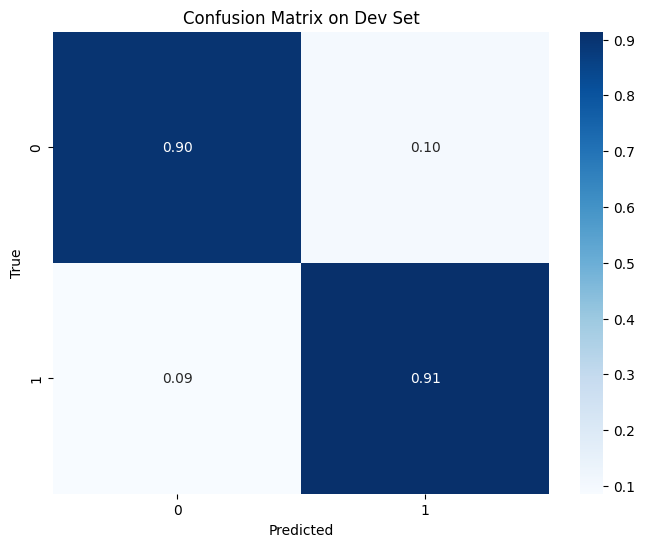

array([[0.90114068, 0.09885932],
       [0.08590069, 0.91409931]])

In [20]:
predictions = roberta_large_model.predict(dev_batches_roberta_large_nli)
prediction_labels = predictions.logits.argmax(axis=-1)

print(classification_report(dev_set['label'], prediction_labels))
plot_confussion(dev_set['label'], prediction_labels, "Confusion Matrix on Dev Set")

135/135 [==============================] - 14s 56ms/step
              precision    recall  f1-score   support

           0       0.91      0.90      0.91       628
           1       0.91      0.92      0.92       719

    accuracy                           0.91      1347
   macro avg       0.91      0.91      0.91      1347
weighted avg       0.91      0.91      0.91      1347



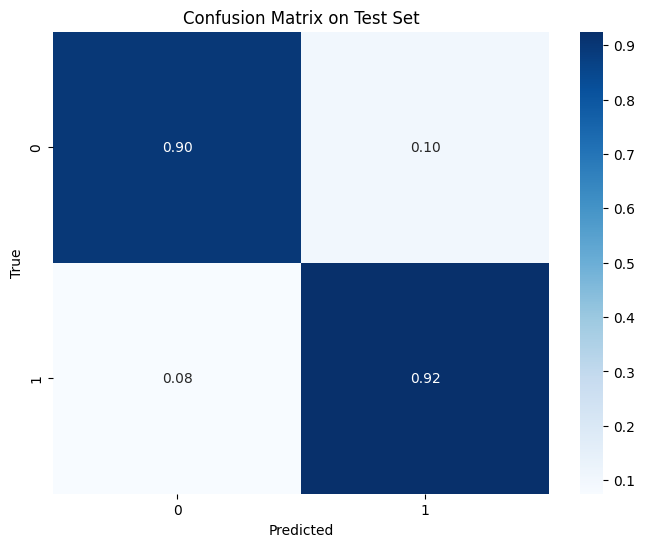

array([[0.89808917, 0.10191083],
       [0.07510431, 0.92489569]])

In [21]:
predictions = roberta_large_model.predict(test_batches_roberta_large_nli)
prediction_labels = predictions.logits.argmax(axis=-1)

print(classification_report(test_set['label'], prediction_labels))
plot_confussion(test_set['label'], prediction_labels, "Confusion Matrix on Test Set")

### Save model checkpoints

In [22]:
if not os.path.exists('nli_large_roberta_model.h5'):
  roberta_large_model.save_weights('nli_large_roberta_model.h5')
  print("Saved model weights to file")

# Sequence Simularity Model

In [23]:
model_name = 'FacebookAI/roberta-base'
roberta_base_tokenizer = AutoTokenizer.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

## Data Preparation

In [24]:
def create_sequence_simularity_dataset(df, tokenizer=roberta_base_tokenizer, batch_size=32):
    """
    Creates a tf.data.Dataset for sentence pair inputs with separate tokenization.

    Args:
        df (pandas.DataFrame): Must contain 'premise', 'hypothesis', and 'label' columns.
        tokenizer (transformers.PreTrainedTokenizer): HuggingFace tokenizer.
        batch_size (int): Batch size for dataset.

    Returns:
        tf.data.Dataset: A batched and tokenized dataset with separate inputs.
    """
    sentences_a = df['premise'].tolist()
    sentences_b = df['hypothesis'].tolist()
    labels = df['label'].tolist()

    # Tokenize each set of sentences separately
    inputs_a = tokenizer(
        sentences_a,
        padding=True,
        truncation=True,
        return_tensors='np'
    )

    inputs_b = tokenizer(
        sentences_b,
        padding=True,
        truncation=True,
        return_tensors='np'
    )

    # Create a dataset with separate inputs for sentence A and sentence B
    dataset = tf.data.Dataset.from_tensor_slices((
        {
            'input_ids_a': inputs_a['input_ids'],
            'attention_mask_a': inputs_a['attention_mask'],
            'input_ids_b': inputs_b['input_ids'],
            'attention_mask_b': inputs_b['attention_mask']
        },
        tf.one_hot(labels, depth=2)  # For binary classification (adjust depth for multi-class)
    ))
    # dataset = dataset.shuffle(buffer_size=len(df))
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

train_batches_simularity = create_sequence_simularity_dataset(train_set, roberta_base_tokenizer, batch_size=32)
dev_batches_simularity = create_sequence_simularity_dataset(dev_set, roberta_base_tokenizer, batch_size=32)
test_batches_simularity = create_sequence_simularity_dataset(test_set, roberta_base_tokenizer, batch_size=32)

## Fine-Tune Sentence Simularity Binary Classification Model

Archetecture based on:https://arxiv.org/pdf/1908.10084

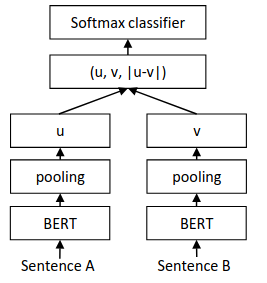
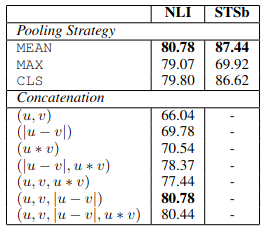



This arctecture was chosen with a classification objective.

In [25]:
def build_sentence_pair_model(model_name='FacebookAI/roberta-base', num_classes=2):
    """
    Builds a sentence pair classification model using FacebookAI/roberta-base.

    Args:
        model_name: Name of the pre-trained FacebookAI/roberta-base model.
        pooling_strategy: Pooling strategy ('mean' or 'cls').
        num_classes: Number of output classes for classification.

    Returns:
        A TensorFlow Keras model.
    """

    # Load BERT model and tokenizer
    roberta_model = TFAutoModel.from_pretrained(model_name)

    N = 6  # Number of layers to freeze
    for layer in roberta_model.roberta.encoder.layer[:N]:
        layer.trainable = False
    print(f"Freezing first {N} layers of {len(roberta_model.roberta.encoder.layer)} roberta")


    # Input layers for Sentence A and Sentence B
    input_ids_a = tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name='input_ids_a')
    attention_mask_a = tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name='attention_mask_a')

    input_ids_b = tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name='input_ids_b')
    attention_mask_b = tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name='attention_mask_b')

    # BERT embeddings for Sentence A
    outputs_a = roberta_model(input_ids_a, attention_mask=attention_mask_a)
    last_hidden_state_a = outputs_a.last_hidden_state

    # BERT embeddings for Sentence B
    outputs_b = roberta_model(input_ids_b, attention_mask=attention_mask_b)
    last_hidden_state_b = outputs_b.last_hidden_state

    # Pooling layer - Mean pooling
    input_mask_expanded_a = tf.cast(tf.expand_dims(attention_mask_a, axis=-1), tf.float32)
    sum_embeddings_a = tf.reduce_sum(last_hidden_state_a * input_mask_expanded_a, axis=1)
    sum_mask_a = tf.reduce_sum(input_mask_expanded_a, axis=1)
    u = sum_embeddings_a / tf.clip_by_value(sum_mask_a, 1e-9, tf.reduce_max(sum_mask_a))

    input_mask_expanded_b = tf.cast(tf.expand_dims(attention_mask_b, axis=-1), tf.float32)
    sum_embeddings_b = tf.reduce_sum(last_hidden_state_b * input_mask_expanded_b, axis=1)
    sum_mask_b = tf.reduce_sum(input_mask_expanded_b, axis=1)
    v = sum_embeddings_b / tf.clip_by_value(sum_mask_b, 1e-9, tf.reduce_max(sum_mask_b))

    # Concatenate u, v, and |u-v|
    concat_layer = tf.keras.layers.Concatenate()([u, v, tf.abs(u - v)])

    x = tf.keras.layers.Dense(256, activation='relu')(concat_layer)
    x = tf.keras.layers.Dropout(0.4)(x)

    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    x = tf.keras.layers.Dense(64, activation='relu')(x)

    # Softmax classifier
    output = tf.keras.layers.Dense(num_classes)(x)

    # Build the model
    model = tf.keras.Model(inputs=[input_ids_a, attention_mask_a,
                                  input_ids_b, attention_mask_b],
                           outputs=output,
                           name="semantic_textual_similarity_model")

    return model

# Example Usage
similarity_model = build_sentence_pair_model(num_classes=2)
similarity_model.summary()

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'roberta.embeddings.position_ids', 'lm_head.dense.weight']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

Freezing first 6 layers of 12 roberta
Model: "semantic_textual_similarity_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 attention_mask_a (InputLay  [(None, None)]               0         []                            
 er)                                                                                              
                                                                                                  
 attention_mask_b (InputLay  [(None, None)]               0         []                            
 er)                                                                                              
                                                                                                  
 tf.expand_dims (TFOpLambda  (None, None, 1)              0         ['attention_mask_a[0][0]']    
 )                          

In [26]:
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
metrics = ['accuracy']

similarity_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)


In [27]:
if os.path.exists('similarity_model.h5'):
  similarity_model.load_weights('similarity_model.h5')
  print("Loaded model weights from file")
else:
  history = similarity_model.fit(train_batches_simularity, validation_data=dev_batches_simularity , epochs=5)
  plot_history(history)

Loaded model weights from file


## Evaluate Sentence Simularity Model

In [28]:
loss, accuracy = similarity_model.evaluate(dev_batches_simularity)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

169/169 [==============================] - 20s 52ms/step - loss: 0.5795 - accuracy: 0.7829
Test Loss: 0.5795308351516724
Test Accuracy: 0.7828910946846008


169/169 [==============================] - 15s 51ms/step
              precision    recall  f1-score   support

           0       0.79      0.75      0.77      2630
           1       0.77      0.82      0.79      2759

    accuracy                           0.78      5389
   macro avg       0.78      0.78      0.78      5389
weighted avg       0.78      0.78      0.78      5389



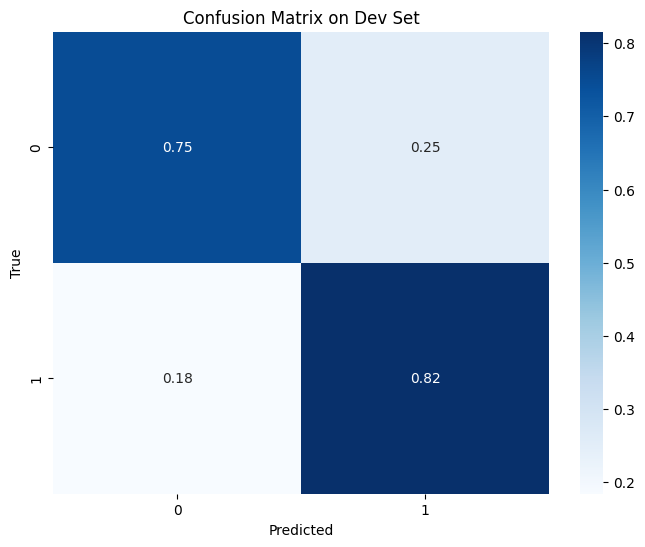

array([[0.7486692 , 0.2513308 ],
       [0.18448713, 0.81551287]])

In [29]:
predictions = similarity_model.predict(dev_batches_simularity)
prediction_labels = predictions.argmax(axis=-1)

print(classification_report(dev_set['label'], prediction_labels))
plot_confussion(dev_set['label'], prediction_labels, "Confusion Matrix on Dev Set")

43/43 [==============================] - 8s 46ms/step
              precision    recall  f1-score   support

           0       0.77      0.76      0.76       628
           1       0.79      0.80      0.80       719

    accuracy                           0.78      1347
   macro avg       0.78      0.78      0.78      1347
weighted avg       0.78      0.78      0.78      1347



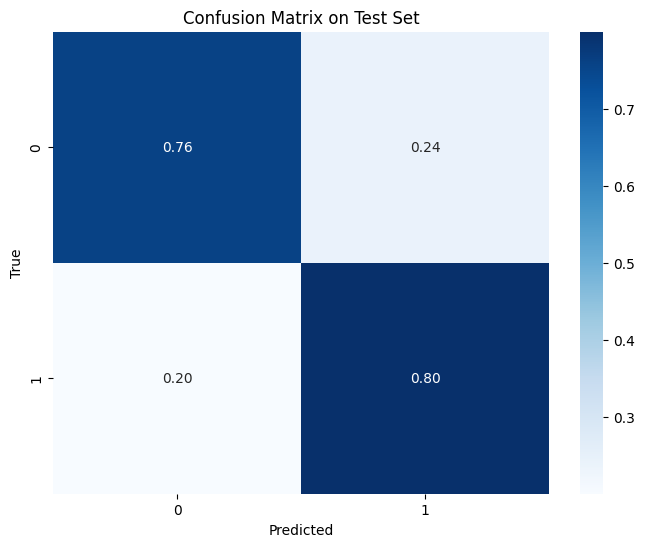

array([[0.75796178, 0.24203822],
       [0.20027816, 0.79972184]])

In [30]:
predictions = similarity_model.predict(test_batches_simularity)
prediction_labels = predictions.argmax(axis=-1)
print(classification_report(test_set['label'], prediction_labels))
plot_confussion(test_set['label'], prediction_labels, "Confusion Matrix on Test Set")

### Save Model Checkpoints

In [31]:
if not os.path.exists('similarity_model.h5'):
  similarity_model.save_weights('similarity_model.h5')
  print("Saved model weights to file")

# Ensamble Learning

Combine the NLI Binary Classification and Sentence Simularity Classification

In [32]:
ENSAMBLE_TRAIN_BATCH_SIZE = 128

## Data Preparation

In [33]:
def create_ensemble_dataset(df, nli_tokenizer, sim_tokenizer, batch_size=16):
  premises = df['premise'].tolist()
  hypotheses = df['hypothesis'].tolist()
  labels = df['label'].tolist()

  inputs_nli = roberta_large_tokenizer(
      premises,
      hypotheses,
      padding=True,
      truncation=True,
      return_tensors="tf"
  )

  # Tokenize each set of sentences separately
  inputs_a = sim_tokenizer(
        premises,
        padding=True,
        truncation=True,
        return_tensors='np'
  )

  inputs_b = sim_tokenizer(
        hypotheses,
        padding=True,
        truncation=True,
        return_tensors='np'
  )

  dataset = tf.data.Dataset.from_tensor_slices((
        {
            'input_ids_nli': inputs_nli['input_ids'],
            'attention_mask_nli': inputs_nli['attention_mask'],
            'input_ids_a': inputs_a['input_ids'],
            'attention_mask_a': inputs_a['attention_mask'],
            'input_ids_b': inputs_b['input_ids'],
            'attention_mask_b': inputs_b['attention_mask']
        },
        tf.one_hot(labels, depth=2)  # For binary classification (adjust depth for multi-class)
  ))
  # dataset = dataset.shuffle(buffer_size=len(df))
  dataset = dataset.batch(batch_size)
  dataset = dataset.prefetch(tf.data.AUTOTUNE)

  return dataset

train_ensemble_dataset = create_ensemble_dataset(train_set, roberta_large_tokenizer, roberta_base_tokenizer, batch_size = ENSAMBLE_TRAIN_BATCH_SIZE)
dev_ensemble_dataset = create_ensemble_dataset(dev_set, roberta_large_tokenizer, roberta_base_tokenizer)
test_ensemble_dataset = create_ensemble_dataset(test_set, roberta_large_tokenizer, roberta_base_tokenizer)

In [35]:
def build_ensemble_model():
    roberta_large_model.trainable = False
    similarity_model.trainable = False

    # Define inputs for the NLI branch
    input_ids_nli = tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name='input_ids_nli')
    attention_mask_nli = tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name='attention_mask_nli')

    # Define inputs for the similarity branch (sentence pair inputs)
    input_ids_a = tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name='input_ids_a')
    attention_mask_a = tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name='attention_mask_a')
    input_ids_b = tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name='input_ids_b')
    attention_mask_b = tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name='attention_mask_b')


    nli_output = roberta_large_model(input_ids_nli, attention_mask=attention_mask_nli).logits
    sim_output = similarity_model([input_ids_a, attention_mask_a, input_ids_b, attention_mask_b])

    # Concatenate logits
    combined = tf.keras.layers.Concatenate()([nli_output, sim_output])  # shape (batch, 4)

    # Small dense layers to learn interactions
    hidden = tf.keras.layers.Dense(16, activation='relu')(combined)
    output = tf.keras.layers.Dense(2, activation='softmax')(hidden)

    # Build the ensemble model
    ensemble_model = tf.keras.Model(
        inputs=[input_ids_nli, attention_mask_nli, input_ids_a, attention_mask_a, input_ids_b, attention_mask_b],
        outputs=output
    )
    return ensemble_model

# Instantiate the ensemble model
ensemble_model = build_ensemble_model()
ensemble_model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids_nli (InputLayer)  [(None, None)]               0         []                            
                                                                                                  
 attention_mask_nli (InputL  [(None, None)]               0         []                            
 ayer)                                                                                            
                                                                                                  
 input_ids_a (InputLayer)    [(None, None)]               0         []                            
                                                                                                  
 attention_mask_a (InputLay  [(None, None)]               0         []                        

In [36]:
ensemble_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Epoch 1/3
191/191 [==============================] - 344s 2s/step - loss: 0.3468 - accuracy: 0.9041 - val_loss: 0.2589 - val_accuracy: 0.9091
Epoch 2/3
191/191 [==============================] - 281s 1s/step - loss: 0.0462 - accuracy: 0.9922 - val_loss: 0.2956 - val_accuracy: 0.9089
Epoch 3/3
191/191 [==============================] - 280s 1s/step - loss: 0.0328 - accuracy: 0.9915 - val_loss: 0.3256 - val_accuracy: 0.9087


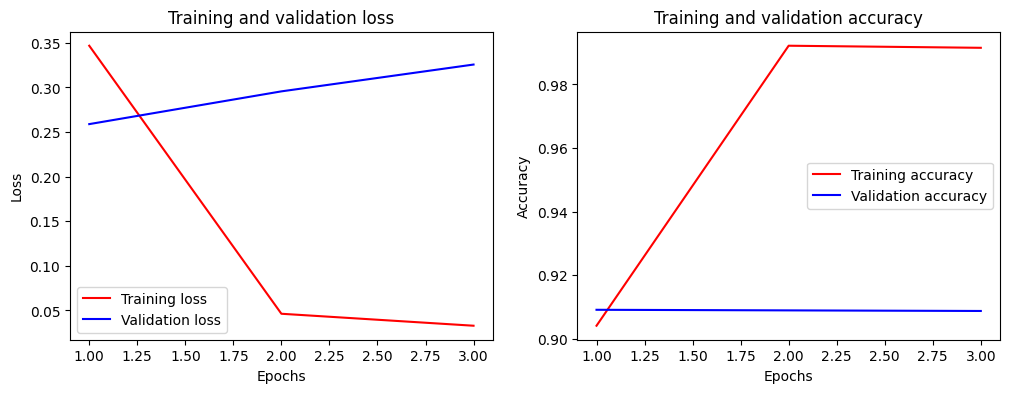

In [37]:
if os.path.exists('ensamble_model.h5'):
  ensemble_model.load_weights('ensamble_model.h5')
  print("Loaded model weights from file")
else:
  history = ensemble_model.fit(train_ensemble_dataset, validation_data=dev_ensemble_dataset , epochs=3)
  plot_history(history)

In [38]:
loss, accuracy = ensemble_model.evaluate(dev_ensemble_dataset)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

337/337 [==============================] - 32s 94ms/step - loss: 0.3256 - accuracy: 0.9087
Test Loss: 0.3256492018699646
Test Accuracy: 0.9087029099464417


337/337 [==============================] - 45s 93ms/step
              precision    recall  f1-score   support

           0       0.91      0.90      0.91      2630
           1       0.91      0.92      0.91      2759

    accuracy                           0.91      5389
   macro avg       0.91      0.91      0.91      5389
weighted avg       0.91      0.91      0.91      5389



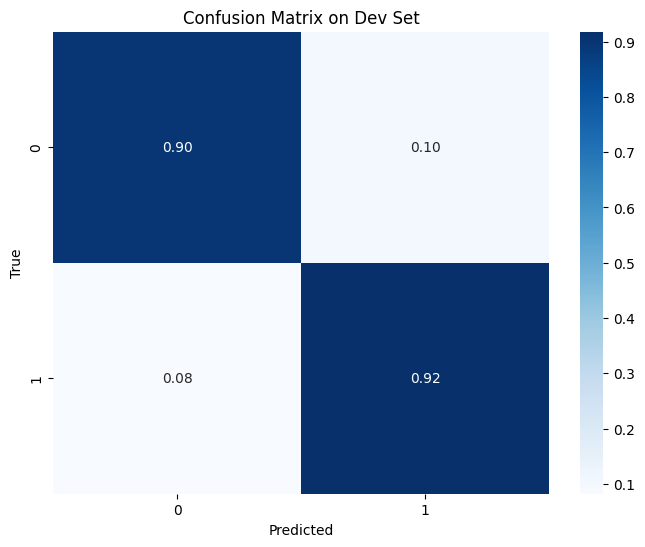

array([[0.89923954, 0.10076046],
       [0.08227619, 0.91772381]])

In [39]:
predictions = ensemble_model.predict(dev_ensemble_dataset)
prediction_labels = predictions.argmax(axis=-1)

print(classification_report(dev_set['label'], prediction_labels))
plot_confussion(dev_set['label'], prediction_labels, "Confusion Matrix on Dev Set")

85/85 [==============================] - 21s 92ms/step
              precision    recall  f1-score   support

           0       0.91      0.89      0.90       628
           1       0.91      0.92      0.92       719

    accuracy                           0.91      1347
   macro avg       0.91      0.91      0.91      1347
weighted avg       0.91      0.91      0.91      1347



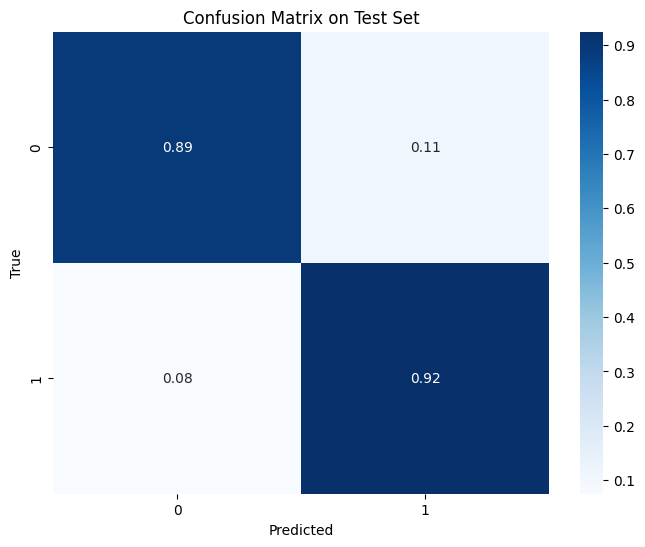

array([[0.8933121 , 0.1066879 ],
       [0.07510431, 0.92489569]])

In [40]:
predictions = ensemble_model.predict(test_ensemble_dataset)
prediction_labels = predictions.argmax(axis=-1)
print(classification_report(test_set['label'], prediction_labels))
plot_confussion(test_set['label'], prediction_labels, "Confusion Matrix on Test Set")

In [41]:
if not os.path.exists('ensamble_model.h5'):
  ensemble_model.save_weights('ensamble_model.h5')
  print("Saved model weights to file")

Saved model weights to file


# Save final model with archetectire and weights

In [42]:
ensemble_model.save("ensamble_model_weights_and_arch.h5", save_format='h5')

/usr/local/lib/python3.11/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Plot Model Comparasion On Sets

In [43]:
train_eval = [roberta_large_model.evaluate(train_batches_roberta_large_nli), similarity_model.evaluate(train_batches_simularity), ensemble_model.evaluate(train_ensemble_dataset)]
dev_eval = [roberta_large_model.evaluate(dev_batches_roberta_large_nli), similarity_model.evaluate(dev_batches_simularity), ensemble_model.evaluate(dev_ensemble_dataset)]
test_eval = [roberta_large_model.evaluate(test_batches_roberta_large_nli), similarity_model.evaluate(test_batches_simularity), ensemble_model.evaluate(test_ensemble_dataset)]

85/85 [==============================] - 8s 92ms/step - loss: 0.2700 - accuracy: 0.9102


In [50]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as mtick

def plot_model_comparison():
  # Model names
  models = ['RoBERTa Large', 'Similarity Model', 'Ensemble Model']

  train_acc = [eval_result[1] for eval_result in train_eval] # Extract accuracy from train_eval
  dev_acc = [eval_result[1] for eval_result in dev_eval]     # Extract accuracy from dev_eval
  test_acc = [eval_result[1] for eval_result in test_eval]    # Extract accuracy from test_eval

  # X locations for the groups
  x = np.arange(len(models))
  width = 0.25  # width of the bars

   # Create the plot
  plt.figure(figsize=(8, 5))
  plt.bar(x - width, train_acc, width, label='Train') # Use train_acc for bar heights
  plt.bar(x, dev_acc, width, label='Dev')           # Use dev_acc for bar heights
  plt.bar(x + width, test_acc, width, label='Test')      # Use test_acc for bar heights

  # Labels and formatting
  plt.title('Transformer Based Model Accuracy Comparison')
  plt.xlabel('Models')
  plt.ylabel('Accuracy')
  plt.ylim(0, 1)
  plt.xticks(x, models)
  plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))  # Show percentages
  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
  plt.grid(axis='y', linestyle='--', alpha=0.7)
  plt.tight_layout()

  plt.show()

In [51]:
def model_comparison_table():
    # Model names
    models = ['RoBERTa Large', 'Similarity Model', 'Ensemble Model']

    # Extract accuracy values from evaluation results
    train_acc = [eval_result[1] for eval_result in train_eval]
    dev_acc = [eval_result[1] for eval_result in dev_eval]
    test_acc = [eval_result[1] for eval_result in test_eval]

    # Create a Pandas DataFrame
    data = {
        'Model': models,
        'Train Accuracy': train_acc,
        'Dev Accuracy': dev_acc,
        'Test Accuracy': test_acc
    }
    df = pd.DataFrame(data)

    # Format accuracy values as percentages
    df['Train Accuracy'] = df['Train Accuracy'].map('{:.2%}'.format)
    df['Dev Accuracy'] = df['Dev Accuracy'].map('{:.2%}'.format)
    df['Test Accuracy'] = df['Test Accuracy'].map('{:.2%}'.format)

    display(df)

In [55]:
# train_eval = [roberta_large_model.evaluate(train_batches_roberta_large_nli), similarity_model.evaluate(train_batches_simularity), ensemble_model.evaluate(train_ensemble_dataset)]
# dev_eval = [roberta_large_model.evaluate(dev_batches_roberta_large_nli), similarity_model.evaluate(dev_batches_simularity), ensemble_model.evaluate(dev_ensemble_dataset)]
# test_eval = [roberta_large_model.evaluate(test_batches_roberta_large_nli), similarity_model.evaluate(test_batches_simularity), ensemble_model.evaluate(test_ensemble_dataset)]

# model_comparison_table()
# plot_model_comparison()